In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops, regionprops_table
import os
from glob import glob
from matplotlib.pyplot import figure

# Compare networks performances

## Check GPU and CUDA and select GPU to use

In [2]:
!nvcc --version
!nvidia-smi

os.environ["CUDA_VISIBLE_DEVICES"]="1" # OS environ is a list of variable in the working environment
#When changing CUDA VISIBLE you are hiding GPUs so in a way selecting the other (only works if you have 2 GPUs)


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:08:53_PST_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0
Tue May 17 12:17:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.00    Driver Version: 470.82.00    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
|  0%   28C    P8    11W / 320W |      8MiB / 11178MiB |      0%      Default |
|                               |       

## Load the data

In [3]:
raw_data_loc = '/home/jupyter/tronador/jupyter-labs/Lab1/Nessim/Outputs/raw/'
lab_data_loc = '/home/jupyter/tronador/jupyter-labs/Lab1/Nessim/Outputs/labeled/'

file_list_raw = [x for x in glob(raw_data_loc+os.sep+"*.npy") if "00" in x and "ch00" in x]
print(f"{len(file_list_raw)} raw files found matching criteria")

file_list_lab = [x for x in glob(lab_data_loc+os.sep+"*.npy") if "00" in x and "ch00" in x]
print(f"{len(file_list_lab)} labeled files found matching criteria")
    
    

12 raw files found matching criteria
12 labeled files found matching criteria


# Analysis on one image 

## Load the data into dataframe

In [4]:
l = 0 # which image you want to load from the path provided 

i = file_list_raw[l]
j = file_list_lab[l]

print(f"{os.path.basename(file_list_raw[l]).rsplit('_raw')[0]} has been loaded")

#load 

im = np.load(i)
lab = np.load(j)

#Put all the infos in a dataframe for easier ploting
properties = ['label', 'area','intensity_max','intensity_mean','centroid_weighted']

region = regionprops_table(lab,intensity_image=im,properties = properties)
df = pd.DataFrame(region)

scan_001_DAPI_004_ROI_converted_decon_ch00 has been loaded


## First metric : intensity profile of all the detected objects 

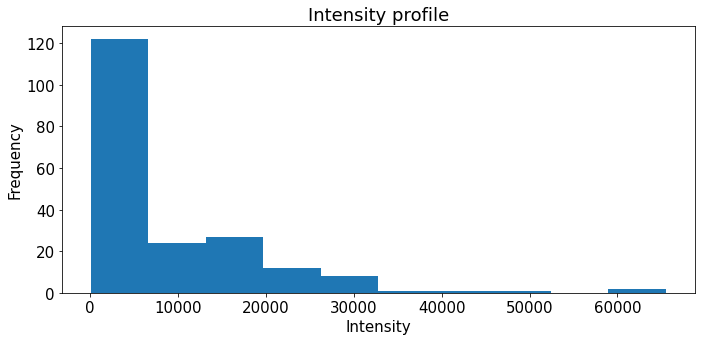

In [62]:
figure(figsize=(10, 5))

#Plot first the intensity profiles
df.intensity_max.plot(kind='hist')
plt.xlabel('Intensity')
plt.title('Intensity profile')
plt.tight_layout()
plt.savefig('Plots/Intensity_profile.png',dpi=300)
plt.show()

## Plot the intensity vs area profile

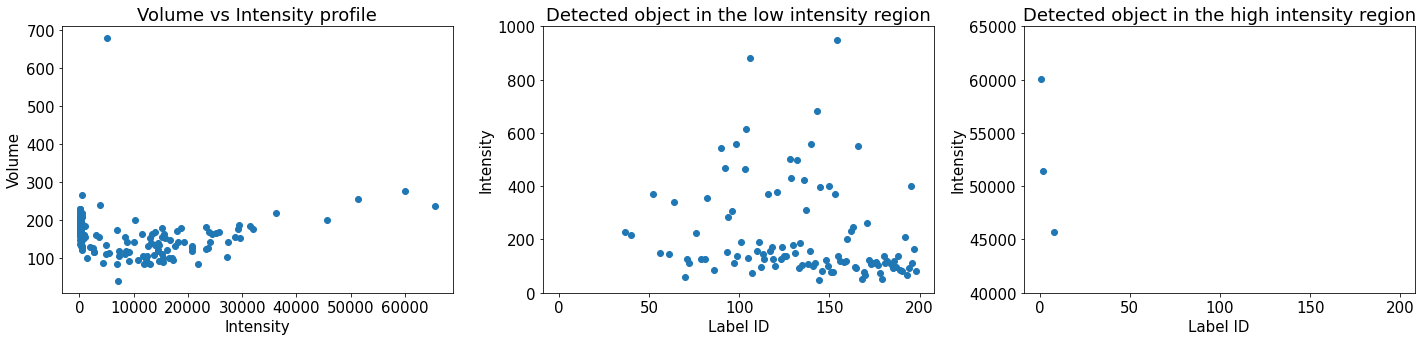

In [105]:
fig , ax = plt.subplots(1,3)
fig.set_size_inches(20,5)

plt.rcParams.update({'font.size': 15})

#Plot the area vs intensity
ax[0].scatter(df.intensity_max.values,df.area.values)
ax[0].set_xlabel('Intensity')
ax[0].set_ylabel('Volume')
ax[0].set_title('Volume vs Intensity profile')

#Plot the low intensity region
ax[1].scatter(df.label.values,df.intensity_max.values)
ax[1].set_ylim(0,1000)
ax[1].set_xlabel('Label ID')
ax[1].set_ylabel('Intensity')
ax[1].set_title('Detected object in the low intensity region')

#Plot the high intensity region 
ax[2].scatter(df.label.values,df.intensity_max.values)
ax[2].set_ylim(40000,65000)
ax[2].set_xlabel('Label ID')
ax[2].set_ylabel('Intensity')
ax[2].set_title('Detected object in the high intensity region')


plt.tight_layout()
plt.savefig('Plots/Global_Metrics.png',dpi=300)
plt.show()

# Plot for all the file loaded all the metrics

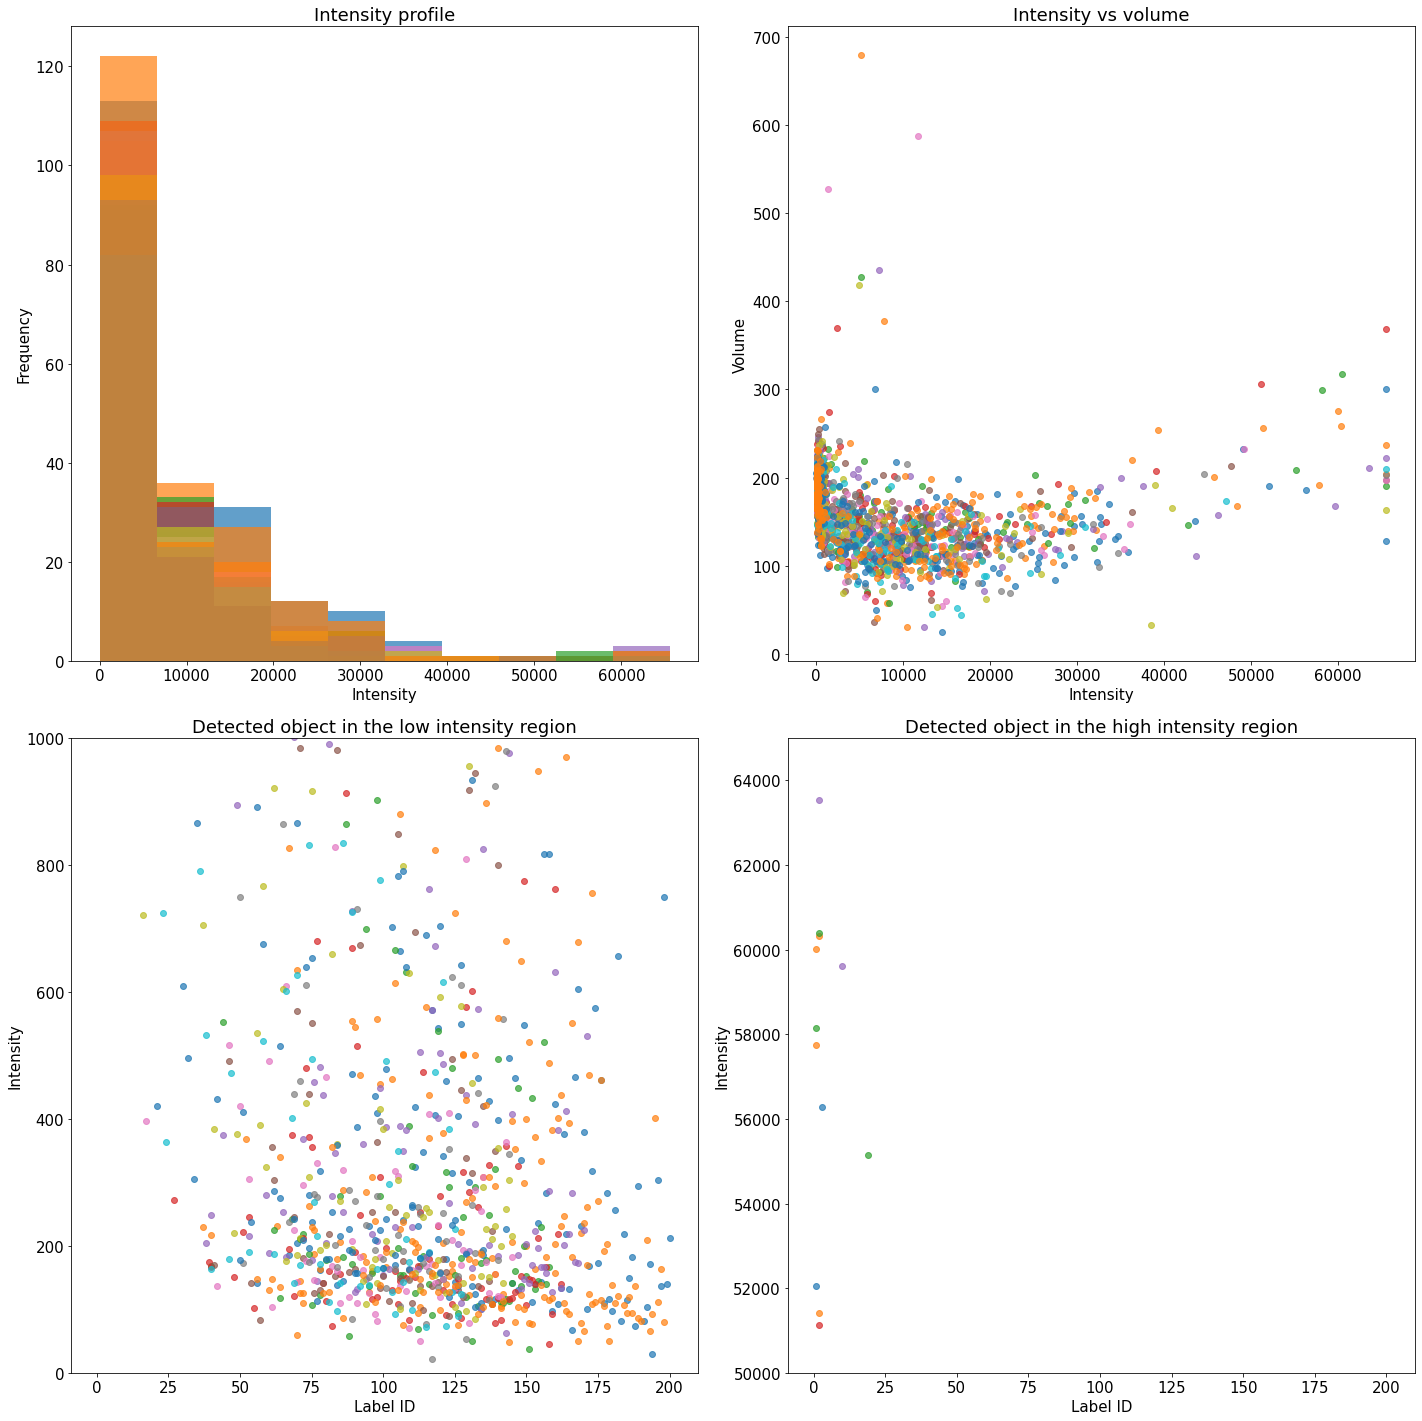

In [106]:
fig , ax = plt.subplots(2,2)
fig.set_size_inches(20,20)

plt.rcParams.update({'font.size': 15})

properties = ['label', 'area','intensity_max','intensity_mean','centroid_weighted']

alpha=0.7 # Transparency of what you want to plot


for i,j in zip(file_list_raw,file_list_lab):
    
    #load the data 
    im = np.load(i)
    lab = np.load(j)
    
    #Put all the infos in a dataframe for easier ploting
    
    region = regionprops_table(lab,intensity_image=im,properties = properties)
    df = pd.DataFrame(region)
    
    #Plot first the intensity profiles
    df.intensity_max.plot(kind='hist',ax=ax[0][0],alpha=alpha)
    
    #Plot the area vs intensity
    ax[0][1].scatter(df.intensity_max.values,df.area.values,alpha=alpha)
    
    #Plot the low intensity region
    ax[1][0].scatter(df.label.values,df.intensity_max.values,alpha=alpha)
    
    
    #Plot the high intensity region 
    ax[1][1].scatter(df.label.values,df.intensity_max.values,alpha=alpha)
    

ax[0][0].set_xlabel("Intensity")
ax[0][0].set_title("Intensity profile")

ax[0][1].set_xlabel("Intensity")
ax[0][1].set_title("Intensity vs volume")
ax[0][1].set_ylabel('Volume')

ax[1][0].set_xlabel('Label ID')
ax[1][0].set_ylabel('Intensity')
ax[1][0].set_title('Detected object in the low intensity region')
ax[1][0].set_ylim(0,1000)  

ax[1][1].set_xlabel('Label ID')
ax[1][1].set_ylabel('Intensity')
ax[1][1].set_title('Detected object in the high intensity region')
ax[1][1].set_ylim(50000,65000)

plt.tight_layout()
plt.savefig('Plots/Global_Metrics_iterated.png',dpi=300)
plt.show()


# Compare 2 networks

## Load the data

In [5]:
#Network 1 

raw_data_loc_1 = '/home/jupyter/tronador/jupyter-labs/Lab1/Nessim/Outputs/raw/'
lab_data_loc_1 = '/home/jupyter/tronador/jupyter-labs/Lab1/Nessim/Outputs/labeled/'

file_list_raw_1 = [x for x in glob(raw_data_loc_1+os.sep+"*.npy") if "00" in x and "ch00" in x]
print(f"{len(file_list_raw)} raw files found matching criteria for network 1")

file_list_lab_1 = [x for x in glob(lab_data_loc_1+os.sep+"*.npy") if "00" in x and "ch00" in x]
print(f"{len(file_list_lab)} labeled files found matching criteria for network 1")
    
# Network 2 

raw_data_loc_2 = '/home/jupyter/tronador/jupyter-labs/Lab1/Ali/Outputs/npy_images/'
lab_data_loc_2 = '/home/jupyter/tronador/jupyter-labs/Lab1/Ali/Outputs/npy_labels/'

file_list_raw_2 = [x for x in glob(raw_data_loc_2+os.sep+"*.npy") if "00" in x and "ch00" in x]
print(f"{len(file_list_raw_2)} raw files found matching criteria for network 2")

file_list_lab_2 = [x for x in glob(lab_data_loc_2+os.sep+"*.npy") if "00" in x and "ch00" in x]
print(f"{len(file_list_lab_2)} labeled files found matching criteria for network 2")


12 raw files found matching criteria for network 1
12 labeled files found matching criteria for network 1
12 raw files found matching criteria for network 2
12 labeled files found matching criteria for network 2


## Analyse 1 image for each Network

In [89]:
l = 0 # which image you want to load from the path provided 

i = file_list_raw_1[l]
j = file_list_lab_1[l]
k = file_list_raw_2[l]
m = file_list_lab_2[l]

print(f"{os.path.basename(file_list_raw_1[l]).rsplit('_raw')[0]} has been loaded for Network 1")
print(f"{os.path.basename(file_list_raw_2[l]).rsplit('_raw')[0]} has been loaded for Network 2")

#load 

im = np.load(i)
lab = np.load(j)

im_2 = np.load(k)
lab_2 = np.load(m)

#Put all the infos in a dataframe for easier ploting

properties = ['label', 'area','intensity_max','intensity_mean','centroid_weighted']

region = regionprops_table(lab,intensity_image=im,properties = properties)
df = pd.DataFrame(region)

region_2 = regionprops_table(lab_2,intensity_image=im_2,properties = properties)
df_2 = pd.DataFrame(region_2)

print('Done!')

scan_001_DAPI_004_ROI_converted_decon_ch00 has been loaded for Network 1
scan_001_DAPI_004_ROI_converted_decon_ch00 has been loaded for Network 2
Done!


## Plot the differences

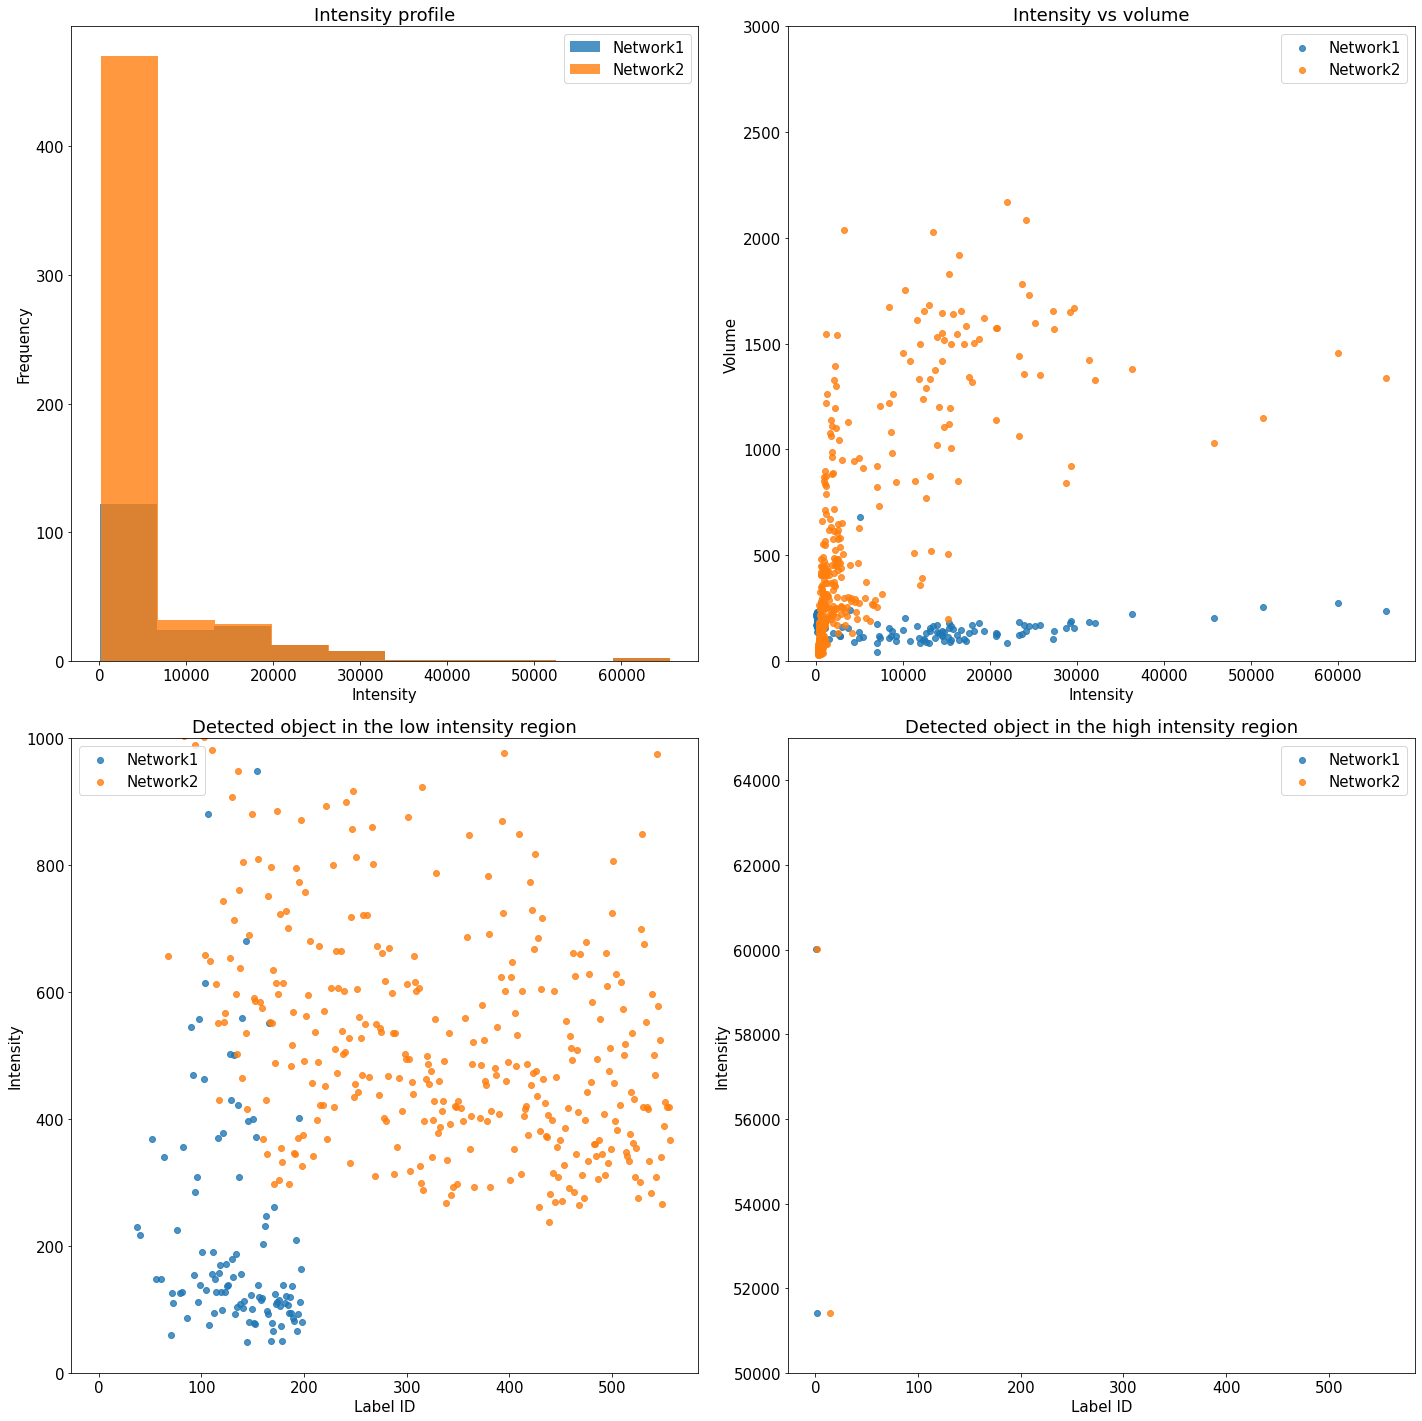

In [107]:
fig , ax = plt.subplots(2,2)
fig.set_size_inches(20,20)

alpha=0.8 # Transparency of what you want to plot

plt.rcParams.update({'font.size': 15})

df.intensity_max.plot(kind='hist',ax=ax[0][0],alpha=alpha,label="Network1")
df_2.intensity_max.plot(kind='hist',ax=ax[0][0],alpha=alpha,label="Network2")
    
#Plot the area vs intensity
ax[0][1].scatter(df.intensity_max.values,df.area.values,alpha=alpha,label="Network1")
ax[0][1].scatter(df_2.intensity_max.values,df_2.area.values,alpha=alpha,label="Network2")

#Plot the low intensity region
ax[1][0].scatter(df.label.values,df.intensity_max.values,alpha=alpha,label="Network1")
ax[1][0].scatter(df_2.label.values,df_2.intensity_max.values,alpha=alpha,label="Network2")


#Plot the high intensity region 
ax[1][1].scatter(df.label.values,df.intensity_max.values,alpha=alpha,label="Network1")
ax[1][1].scatter(df_2.label.values,df_2.intensity_max.values,alpha=alpha,label="Network2")


ax[0][0].set_xlabel("Intensity")
ax[0][0].set_title("Intensity profile")
ax[0][0].legend()

ax[0][1].set_xlabel("Intensity")
ax[0][1].set_title("Intensity vs volume")
ax[0][1].set_ylabel('Volume')
ax[0][1].set_ylim(0,3000) # To be tailored
ax[0][1].legend()

ax[1][0].set_xlabel('Label ID')
ax[1][0].set_ylabel('Intensity')
ax[1][0].set_title('Detected object in the low intensity region')
ax[1][0].set_ylim(0,1000)  
ax[1][0].legend()

ax[1][1].set_xlabel('Label ID')
ax[1][1].set_ylabel('Intensity')
ax[1][1].set_title('Detected object in the high intensity region')
ax[1][1].set_ylim(50000,65000)
ax[1][1].legend()

plt.tight_layout()
plt.savefig('Plots/Global_Metrics_2_Networks.png',dpi=300)
plt.show()

## Plot for all the file the comparison 

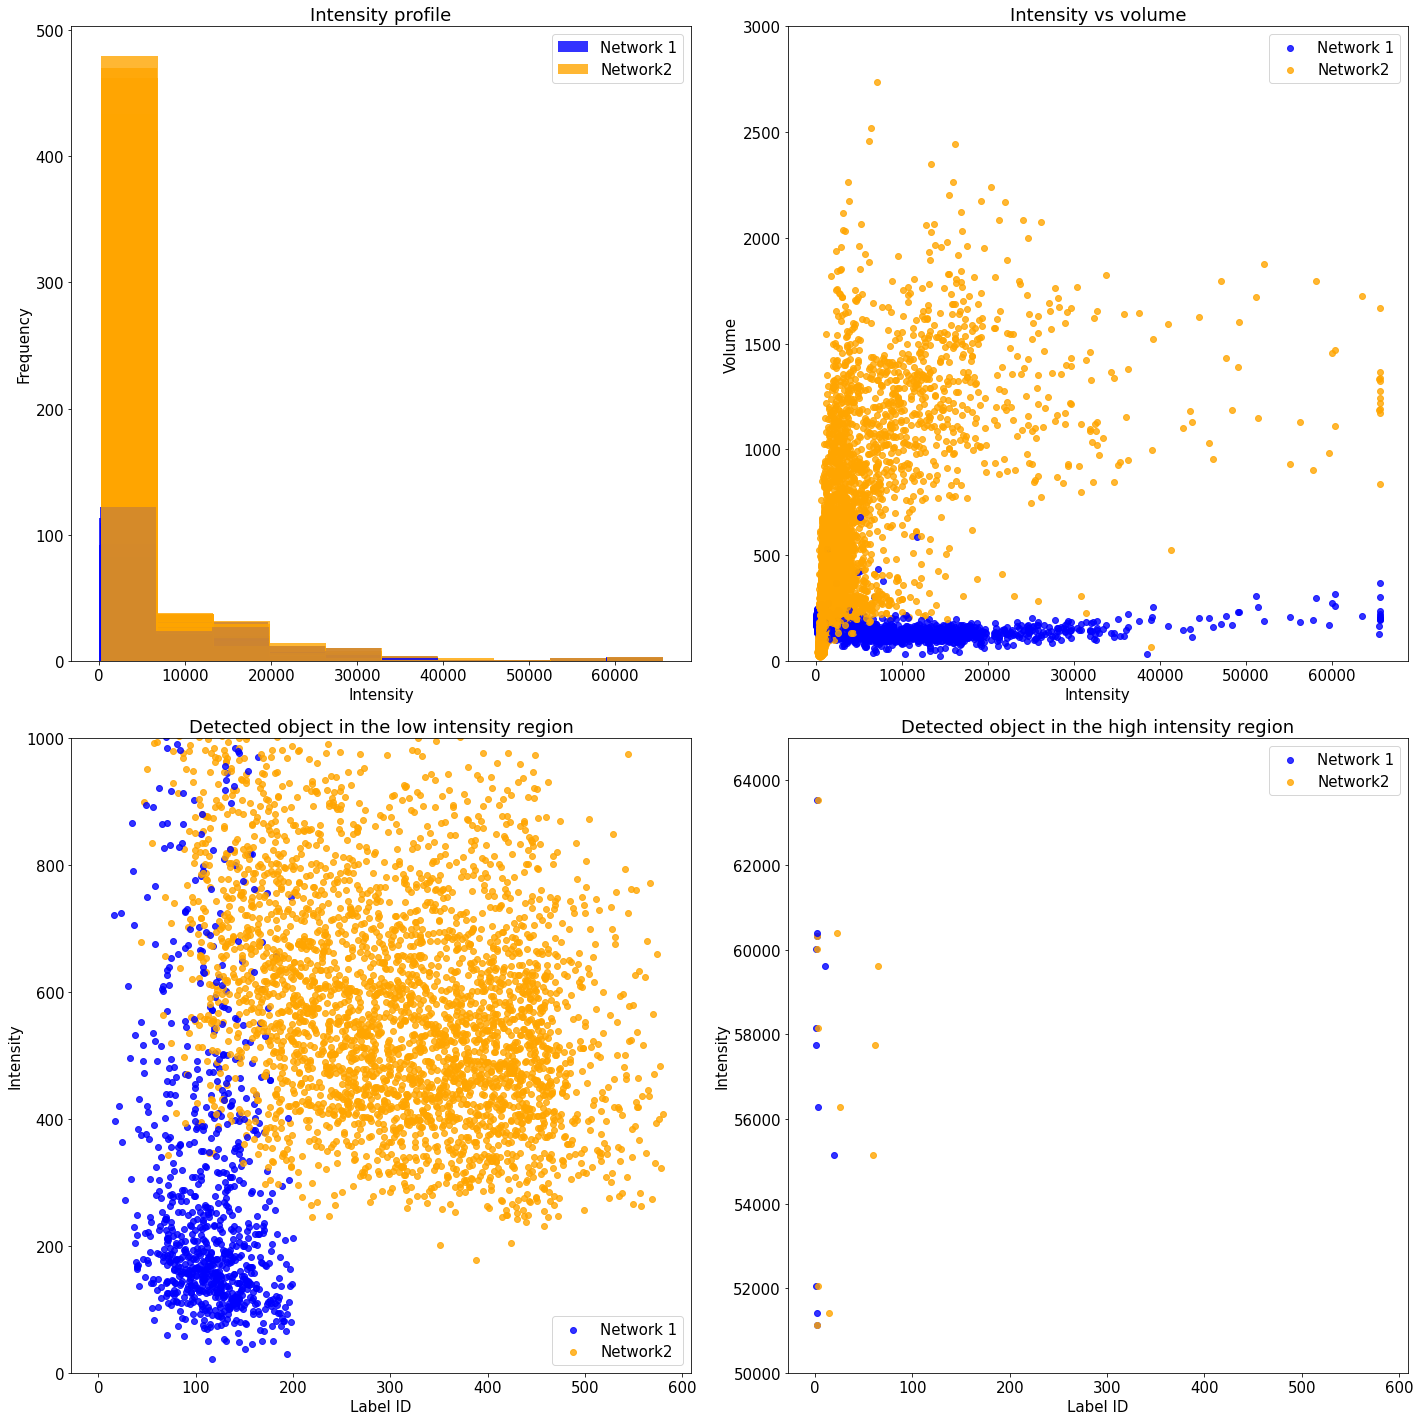

In [9]:
fig , ax = plt.subplots(2,2)
fig.set_size_inches(20,20)

alpha=0.8 # Transparency of what you want to plot

plt.rcParams.update({'font.size': 15})

color_1 = "blue"
color_2 = "orange"


for i,j,k,m in zip(file_list_raw_1,file_list_lab_1,file_list_raw_2,file_list_lab_2):
    
    #load the data 
    im = np.load(i)
    lab = np.load(j)
    
    im_2 = np.load(k)
    lab_2 = np.load(m)
    
    #Put all the infos in a dataframe for easier ploting
    
    region = regionprops_table(lab,intensity_image=im,properties = properties)
    df = pd.DataFrame(region)
    
    region_2 = regionprops_table(lab_2,intensity_image=im_2,properties = properties)
    df_2 = pd.DataFrame(region_2)
    
    df.intensity_max.plot(kind='hist',ax=ax[0][0],alpha=alpha,color=color_1)
    df_2.intensity_max.plot(kind='hist',ax=ax[0][0],alpha=alpha,color=color_2)

    #Plot the area vs intensity
    ax[0][1].scatter(df.intensity_max.values,df.area.values,alpha=alpha,color=color_1)
    ax[0][1].scatter(df_2.intensity_max.values,df_2.area.values,alpha=alpha,color=color_2)

    #Plot the low intensity region
    ax[1][0].scatter(df.label.values,df.intensity_max.values,alpha=alpha,color=color_1)
    ax[1][0].scatter(df_2.label.values,df_2.intensity_max.values,alpha=alpha,color=color_2)


    #Plot the high intensity region 
    ax[1][1].scatter(df.label.values,df.intensity_max.values,alpha=alpha,color=color_1)
    ax[1][1].scatter(df_2.label.values,df_2.intensity_max.values,alpha=alpha,color=color_2)


ax[0][0].legend(['Network 1', 'Network2'])
ax[0][1].legend(['Network 1', 'Network2'])
ax[1][0].legend(['Network 1', 'Network2'])
ax[1][1].legend(['Network 1', 'Network2'])
       
    
    
ax[0][0].set_xlabel("Intensity")
ax[0][0].set_title("Intensity profile")


ax[0][1].set_xlabel("Intensity")
ax[0][1].set_title("Intensity vs volume")
ax[0][1].set_ylabel('Volume')
ax[0][1].set_ylim(0,3000) # To be tailored


ax[1][0].set_xlabel('Label ID')
ax[1][0].set_ylabel('Intensity')
ax[1][0].set_title('Detected object in the low intensity region')
ax[1][0].set_ylim(0,1000)  

ax[1][1].set_xlabel('Label ID')
ax[1][1].set_ylabel('Intensity')
ax[1][1].set_title('Detected object in the high intensity region')
ax[1][1].set_ylim(50000,65000)

plt.tight_layout()
plt.savefig('Plots/Global_Metrics_2_Networks_iterated_2.svg',dpi=300)
plt.show()
